In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from keras.utils import to_categorical
from keras.models import Model
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, Input, Dropout
from keras.callbacks import EarlyStopping

from keras.layers import concatenate

Using TensorFlow backend.


In [345]:
from sklearn.metrics import f1_score, confusion_matrix, recall_score, precision_score, make_scorer
from sklearn.model_selection import KFold, cross_validate


from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline


## Parameters

In [433]:
PREFILTER = True
PREFILTER_THRESHOLD = 0.2 # Data excluded if Brand variance greather than 0.2M or less than -0.2M

WINDOW_SIZE = 13 # Timeseries window size in months

MULTILABEL = False

UNDERSAMPLE = True
UNDERSAMPLE_RATIO = 0.6 #  Amount of data with no comment =  Amount of data with comment / UNDERSAMPLE_RATIO
EXTRA_TEST_DATA = 100 # Amount of data thrown out when undersampling to include in the test set

OVERSAMPLE = True

AUGMENT_DATA = True

DATA = ["Variance"] # "Variance", "All", 
MODEL = "LSTM"    # 


## Loading Data

commentaries_to_pickle.py to save commentary spreedsheet to pickle

In [423]:
from helper_save_load import load_from_pickle

df_c = load_from_pickle("data/Labeled_comments2.pkl")
#df_c.drop(columns=['Safeway'], inplace=True) # If Labeled_comments.pkl

In [424]:
# These brands are in df_c but do not appear in the variance dataframe df_v
ignored_brands = ["IGNORE",
"57-CAMAY BAR SOAP Brand",
"71-LBP SH/CD Roll-up Brand",
"72-LBP SHOWER Roll-up Brand"]

df_c = df_c[~df_c["Brand_1"].isin(ignored_brands)]

In [425]:
df_c.insert(16, "NoComm", df_c["Commentaries"].isnull())
df_c.insert(16, "Other", (df_c[['Promo', 'Phasing', 'SP&D', 'POS']].sum(axis=1) == 0) & ~df_c['NoComm'])
df_c["Month"] = pd.to_datetime(df_c["Month"]).dt.strftime("%b_%Y")

In [426]:
label_cols = ['Promo', 'Phasing', 'SP&D', 'POS', 'Other', 'NoComm']

territory_label_cols = df_c.columns[18:31].to_list()
territory_labels = df_c[territory_label_cols]

In [427]:
df_a, df_f, df_v = load_from_pickle("data/dataframes_Dollars.pickle")
del df_a, df_f

In [428]:
territories = [territory for territory, values in df_v.groupby(['Territory']).groups.items()]

## Pre-Filtering Data
Including data if variance is greater than the 0.2M threshold

In [429]:
test = df_c[(~df_c["Num"].duplicated())]
len(test[test["NoComm"] == 1]) / len(test) # Fraction of number of brand-month pairs with no commentaries

0.7415946205571565

In [430]:
if PREFILTER:
    df_c = df_c[(df_c["Variance"] >= PREFILTER_THRESHOLD) | (df_c["Variance"] <= -PREFILTER_THRESHOLD)]

In [431]:
test = df_c[(~df_c["Num"].duplicated())]
len(test[test["NoComm"] == 1]) / len(test) #Fraction of number of brand-month pairs with no commentaries after filtering

0.12237762237762238

## Removing multiclass labels

Rows with multiple positive class labels are changed to a single label according to the importance of the class

In [434]:
if not MULTILABEL:
    CLASS_PRIORITY = ["Promo", "SP&D", "Phasing", "POS"] # Most important class to predict to least

    print('Number of multiclass labels before:', sum(df_c[label_cols].sum(axis=1) > 1))

    for idx, row in df_c[df_c[label_cols[:4]].sum(axis=1) > 1][label_cols[:4]].iterrows():
        positive_label_idx = min([CLASS_PRIORITY.index(c) for c in row[row > 0].index])
        negative_labels = CLASS_PRIORITY[:]
        negative_labels.pop(positive_label_idx) # List of columns to set to zero
        df_c.loc[idx, negative_labels] = 0

    print('Number of multiclass labels after:', sum(df_c[label_cols].sum(axis=1) > 1))

Number of multiclass labels before: 38
Number of multiclass labels after: 0


## Reshaping Data

In [435]:
TR_BR_grouped = df_v.groupby(["Territory", "Brand"]).sum()

In [436]:
# Relevant Territories Dictionary
# Also Grouping LCL, Sobeys, Metro, OOH
# METRO ONT/QUE FDS AND HPC? (23)
# Liquidation?

# territory_dict = {"WM":[27], "Sobeys":[11, 12, 13, 14], "Sobeys W":[14], "SobeysQ":[12],
#                   "Metro":[8, 9, 10], "Metro ON":[8, 10], "Metro Q":[9, 10], "SDM":[4], 
#                   "LCL":[1, 2, 3], "Costco":[28], "MCK":[5], "PJC":[6], "OOH":[22, 23, 24, 25]}

territory_dict = {"WM":["M7400 - WALMART"], 
                  "Sobeys":["M5200 - SOBEYS ONT", "M5201 - SOBEYS QUE", "M5202 - SOBEYS ATL", "M5203 - SOBEYS WEST/SAFEWAY/THRIFTY"],
                  "Sobeys W":["M5203 - SOBEYS WEST/SAFEWAY/THRIFTY"],
                  "SobeysQ":["M5201 - SOBEYS QUE"],
                  "Metro":["M5100 - METRO ONT IC", "M5101 - METRO QUE IC", "M5102 - METRO ONT/QUE FDS AND HPC"],
                  "Metro ON":["M5100 - METRO ONT IC"],
                  "Metro Q":["M5101 - METRO QUE IC"],
                  "SDM":["M4400 - SHOPPERS D.M."], 
                  "LCL":["M4000 - LCL HPC", "M4001 - LCL FDS exclude IC", "M4002 - LCL IC"],
                  "Costco":["M7500 - CANADA COSTCO"],
                  "MCK":["M5000 - MCKESSON"], 
                  "PJC":["M5001 - JEAN COUTU"], 
                  "OOH":["M7300 - QUE OOH", "M7301 - ONT OOH", "M7303 - NATIONAL OOH MDs", "M7304 - ATLANTIC RETAIL AND OOH"]}


Summing variances for all associated subterritories for each labeled territory and placing them in a dictionary

In [ ]:
variance_dict = {}
for territory, subterritories in territory_dict.items():
    summed_variance = pd.DataFrame()
    for subterritory in subterritories:
        summed_variance = summed_variance.add(TR_BR_grouped.loc[subterritory], fill_value=0)
        
    variance_dict[territory] = summed_variance

In [ ]:
for t, v in variance_dict.items():
    print(t, v.shape)

In [ ]:
territory_label_cols 
# +1 for no territory associated (14 total) But what variance data to use for the final label?

Variance time series (all months) for labeled territories. Zeros if no data for brand-territory.

In [440]:
# Brand x territory x months
# Row of zeros if empty
brands = df_v["Brand"].unique()
months = df_v.columns[8:]

all_brands_variance = []

for brand in brands:
    temp = []
    for territory in territory_label_cols:
        if brand in variance_dict[territory].index:
            temp.append(variance_dict[territory].loc[brand].values)
        else:
            temp.append(np.zeros(len(months)))
    all_brands_variance.append(temp)
    
all_brands_variance = np.array(all_brands_variance)
all_brands_variance.shape

(136, 13, 34)

For each unique brand-month pair (known to be unique by the "Num" column) we take a 12 month window of data for each labeled territory. Thus the output should have #unique brand-month pairs * 13 territories rows.

The labels are generated as well. The default label for when a territory is not involved is [0, 0, 0, 0, 0]

In [441]:
# Generates full list of 12 month timeseries windows and corresponding class labels
# for every *unique* brand-month pair in commentary spreadsheet

labels = []
BR_TR_timeseries_windows = []
previous_commentary_num = -1
brand_month_labels = None

for idx, row in df_c.iterrows():
    brand_idx = np.where(brands==row["Brand_1"])[0][0]
    month_idx = np.where(months==row["Month"])[0][0]
    t_idx = np.flatnonzero(row.fillna(0)[territory_label_cols]) # Index of territory_label for this row
    
    # Due to splitting of commentaries we have repeated brand-month pairs in data
    # Keeping track of which commentary so we don't repeat its timeseries
    current_commentary_num = row["Num"] 
    
    if current_commentary_num != previous_commentary_num:
        # First instance of brand-month pair
        labels.append(brand_month_labels)
        
        brand_month_labels = np.zeros((len(territory_label_cols), len(label_cols)), dtype=int)
        brand_month_labels[:, 5] = 1 # Default NoComm
        
        if t_idx.size > 0:
            brand_month_labels[t_idx[0]] = row[label_cols].fillna(0).values
        
        for i in range(len(territory_label_cols)):

            # Appending 12 month windows per brand per territory as input
            if month_idx - WINDOW_SIZE < 0:
                padding = np.zeros(WINDOW_SIZE - month_idx - 1) # pad with zeros if less than 12
                window = np.concatenate((padding, all_brands_variance[brand_idx, i, :month_idx+1]))
            else:
                window = all_brands_variance[brand_idx, i, (month_idx-WINDOW_SIZE+1):month_idx+1]
            BR_TR_timeseries_windows.append(window)
    else:
        # Repeated instances of brand-month pair
        if t_idx.size > 0:
            brand_month_labels[t_idx[0]] = row[label_cols].fillna(0).values

    previous_commentary_num = current_commentary_num
    
labels.append(brand_month_labels) # Append the final labels
BR_TR_timeseries_windows = np.array(BR_TR_timeseries_windows)
BR_TR_labels = np.vstack(labels[1:])
BR_TR_timeseries_windows /= 1e6 

print("X data shape:", BR_TR_timeseries_windows.shape) # 286 brand-month pairs * 13 territories, 12 months
print("y data shape:", BR_TR_labels.shape)             # 286 brand-month pairs * 13 territories, 5 labels

X data shape: (3718, 13)
y data shape: (3718, 6)


In [442]:
df_c.Num.nunique() # Number of unique brand-month pairs i.e. number of unsplit commentaries 

286

In [443]:
sum(BR_TR_labels) # Class memberships (Promo, Phasing, SP&D, POS, Other, NoComm)

array([ 131,   81,    9,   86,   28, 3383])

## Undersampling

In [24]:
x = np.where((BR_TR_timeseries_windows.sum(axis=1)==0) & (BR_TR_labels[:, 5]==0)x)[0]

In [25]:
nums = [df_c.Num.unique()[i//13] for i in x]

In [ ]:
# 0 variance data but still have a comment label
# Issue comes from Sobeys/Metro groupings
df_c[df_c.Num.isin(nums)][["Num"] + territory_label_cols]

In [454]:
if UNDERSAMPLE:
    
    print("Length of data:",len(BR_TR_timeseries_windows))
    print("No Comment:", sum(BR_TR_labels[:, 5] == 1))
    print("With Comment:", sum(BR_TR_labels[:, 5] == 0))
    
    nonzero_data = np.where(BR_TR_timeseries_windows.sum(axis=1) != 0)
    X = BR_TR_timeseries_windows[nonzero_data]
    y = BR_TR_labels[nonzero_data]
    
    no_comment_idx = np.where(y[:, 5] == 1)[0]
    with_comment_idx = np.where(y[:, 5] == 0)[0]

    no_comment_count = sum(y[:, 5] == 1)   
    with_comment_count = sum(y[:, 5] == 0)
    
    np.random.shuffle(no_comment_idx)
    undersample_no_comment_idx = no_comment_idx[:int(with_comment_count/UNDERSAMPLE_RATIO)]
    excluded_data_idx = no_comment_idx[int(with_comment_count/UNDERSAMPLE_RATIO):]
    
    
    undersample_idx = np.concatenate((undersample_no_comment_idx, with_comment_idx))
    undersample_idx.sort(kind='mergesort') # Preserving order of data
    
    excluded_data = X[excluded_data_idx]
    excluded_labels = y[excluded_data_idx]
    
    X = X[undersample_idx]
    y = y[undersample_idx]

Length of data: 3718
No Comment: 3383
With Comment: 335


In [445]:
print("Length of data:", len(X))
print("No Comment:", sum(y[:, 5] == 1))
print("With Comment:", sum(y[:, 5] == 0))

Length of data: 856
No Comment: 535
With Comment: 321


In [446]:
# Time series with zero data Before and after
sum(BR_TR_timeseries_windows.sum(axis=1)==0), sum(X.sum(axis=1) == 0) 

(1075, 0)

## Making a test set

In [463]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Add data to test set that was thrown out when undersampling
if UNDERSAMPLE:
    X_test = np.concatenate((X_test, excluded_data[:EXTRA_TEST_DATA]))
    y_test = np.concatenate((y_test, excluded_labels[:EXTRA_TEST_DATA]))

## Oversampling small classes

In [464]:
# Naive oversampling
if OVERSAMPLE:
    print("Class memberships before:", sum(y_train))
#     ros = RandomOverSampler(ratio={0:300, 1:300, 2:100, 3:300, 4:50, 5:sum(y_train[:, 5])})
    ros = RandomOverSampler()
    X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
    print("Class memberships after:", sum(y_resampled))

Class memberships before: [ 96  58   6  66  18 440]
Class memberships after: [440 440 440 440 440 440]


## Augmenting data with noise

In [54]:
# Adding noise to variance data to generate more samples to learn from

## Plotting model

In [32]:
import matplotlib.pyplot as plt

%matplotlib inline

def plot_model(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title('model loss')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.title('model accuracy')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

## Random Forest

In [447]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

In [465]:
ros = RandomOverSampler()
X_binary, y_binary = ros.fit_resample(X_train, 1 -  y_train[:, 5])

In [466]:
pre = []
rec = []
fs = []
gms = []
wa = []

for _ in range(100):
    rf = RandomForestClassifier(200)
    rf.fit(X_binary, y_binary) # 1 if comment, 0 if no comment
    
    predictions = rf.predict(X_test)
    pre.append(precision_score(1 - y_test[:, 5], predictions))
    rec.append(recall_score(1 - y_test[:, 5], predictions))
    fs.append(f1_score(1 - y_test[:, 5], predictions))
    gms.append(geometric_mean_score(1 - y_test[:, 5], predictions, average='binary'))
    wa.append(balanced_accuracy_score(1 - y_test[:, 5], predictions))

In [467]:
print(np.mean(pre), np.mean(rec), np.mean(fs), np.mean(gms), np.mean(wa))

0.524794521400435 0.5745454545454546 0.5482794631947523 0.6753242162822803 0.6844522144522144


In [243]:
predictions = rf.predict(X_test)

In [244]:
sum(predictions)

100

In [245]:
sum(1 - y_test[:,5])

70

In [246]:
conf_matrix = confusion_matrix(1 - y_test[:,5], predictions)
conf_matrix

array([[142,  58],
       [ 28,  42]])

In [247]:
tn, fp, fn, tp = conf_matrix.ravel()

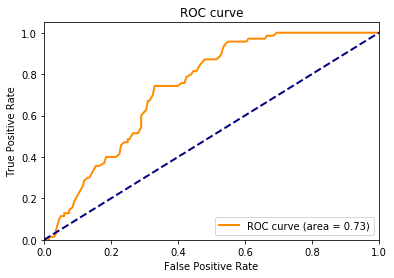

In [248]:
score = rf.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(1 - y_test[:, 5], score, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

In [249]:
print('Weighted Accuracy', balanced_accuracy_score(1 - y_test[:, 5], predictions))
print('Geometric mean of recall and specificity:', geometric_mean_score(1 - y_test[:,5], predictions), '\n')
print(classification_report_imbalanced(1 - y_test[:,5], predictions))

Weighted Accuracy 0.655
Geometric mean of recall and specificity: 0.6526867548832288 

                   pre       rec       spe        f1       geo       iba       sup

          0       0.84      0.71      0.60      0.77      0.65      0.43       200
          1       0.42      0.60      0.71      0.49      0.65      0.42        70

avg / total       0.73      0.68      0.63      0.70      0.65      0.43       270



In [250]:
print(recall_score(1-y_test[:, 5], predictions))
print(precision_score(1-y_test[:, 5], predictions))
print(f1_score(1-y_test[:, 5], predictions))
print(accuracy_score(1-y_test[:, 5],predictions))

0.6
0.42
0.49411764705882355
0.6814814814814815


## No Comment / Comment Model

In [468]:
X_binary = X_binary.reshape(*X_binary.shape, 1)
X_test = X_test.reshape(*X_test.shape, 1)

In [469]:
pre = []
rec = []
fs = []
gms = []
wa = []

for _ in range(10):
# Binary Classifcation (Comment / No Comment)
    model = Sequential()
    model.add(LSTM(150, input_shape=(WINDOW_SIZE, 1), dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True) # restore_best_weights available in newer keras
    # filepath = 'models/binary_model.h5'
    # checkpoint = ModelCheckpoint(filepath, monitor='val-loss', save_best_only=True)

    model.fit(X_binary, y_binary,
                  validation_data=(X_test, 1 - y_test[:, 5]),
                  epochs=50, batch_size=16, verbose=0)


    predictions = model.predict_classes(X_test)
    pre.append(precision_score(1 - y_test[:, 5], predictions))
    rec.append(recall_score(1 - y_test[:, 5], predictions))
    fs.append(f1_score(1 - y_test[:, 5], predictions))
    gms.append(geometric_mean_score(1 - y_test[:, 5], predictions, average='binary'))
    wa.append(balanced_accuracy_score(1 - y_test[:, 5], predictions))

In [470]:
print(np.mean(pre), np.mean(rec), np.mean(fs), np.mean(gms), np.mean(wa))

0.4306638690805267 0.522077922077922 0.46678236660506417 0.6042082958033939 0.6182184482184482


In [229]:
predictions = model.predict_classes(X_test)

In [230]:
print('Weighted Accuracy', balanced_accuracy_score(1 - y_test[:, 5], predictions))
print('Geometric mean of recall and specificity:', geometric_mean_score(1 - y_test[:,5], predictions), '\n')
print(classification_report_imbalanced(1 - y_test[:,5], predictions))

Weighted Accuracy 0.6953571428571428
Geometric mean of recall and specificity: 0.6952902785373685 

                   pre       rec       spe        f1       geo       iba       sup

          0       0.87      0.70      0.69      0.78      0.70      0.48       200
          1       0.45      0.69      0.70      0.54      0.70      0.48        70

avg / total       0.76      0.70      0.69      0.72      0.70      0.48       270



In [231]:
print(recall_score(1-y_test[:, 5], predictions))
print(precision_score(1-y_test[:, 5], predictions))
print(f1_score(1-y_test[:, 5], predictions))
print(accuracy_score(1-y_test[:, 5],predictions))

0.6857142857142857
0.4485981308411215
0.5423728813559322
0.7


In [161]:
# from keras.models import load_model
# model = load_model('models/binary_model.h5')

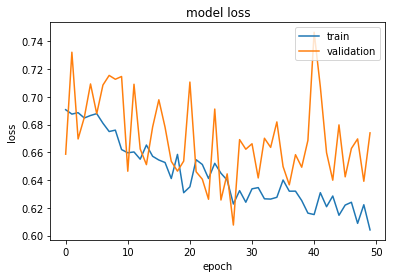

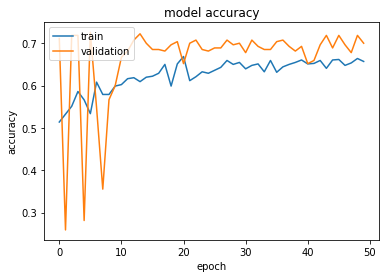

In [232]:
plot_model(history)

## Dense Binary Model

In [241]:
X_binary = X_binary.reshape(X_binary.shape[:2])
X_test = X_test.reshape(X_test.shape[:2])

In [174]:
# Binary Classifcation (Comment / No Comment)
model = Sequential()
model.add(Dense(100, input_shape=(WINDOW_SIZE,)))
model.add(Dense(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True) 

history = model.fit(X_binary, y_binary,
              validation_data=(X_test, 1 - y_test[:, 5]),
              epochs=50, batch_size=8)

Train on 852 samples, validate on 270 samples
Epoch 1/50
852/852 [==============================] - 1s 707us/step - loss: 0.6903 - acc: 0.5563 - val_loss: 0.7022 - val_acc: 0.6778
Epoch 2/50
852/852 [==============================] - 0s 214us/step - loss: 0.6823 - acc: 0.6232 - val_loss: 0.7117 - val_acc: 0.6704
Epoch 3/50
852/852 [==============================] - 0s 215us/step - loss: 0.6786 - acc: 0.6150 - val_loss: 0.7311 - val_acc: 0.5815
Epoch 4/50
852/852 [==============================] - 0s 212us/step - loss: 0.6788 - acc: 0.6291 - val_loss: 0.6884 - val_acc: 0.6815
Epoch 5/50
852/852 [==============================] - 0s 215us/step - loss: 0.6772 - acc: 0.6009 - val_loss: 0.6911 - val_acc: 0.6926
Epoch 6/50
852/852 [==============================] - 0s 215us/step - loss: 0.6774 - acc: 0.6268 - val_loss: 0.6984 - val_acc: 0.6889
Epoch 7/50
852/852 [==============================] - 0s 214us/step - loss: 0.6799 - acc: 0.6162 - val_loss: 0.7235 - val_acc: 0.6407
Epoch 8/50
852/8

In [175]:
predictions = model.predict_classes(X_test)

In [176]:
print('Weighted Accuracy', balanced_accuracy_score(1 - y_test[:, 5], predictions))
print('Geometric mean of recall and specificity:', geometric_mean_score(1 - y_test[:,5], predictions), '\n')
print(classification_report_imbalanced(1 - y_test[:,5], predictions))

Weighted Accuracy 0.5407754010695187
Geometric mean of recall and specificity: 0.46966821831386213 

                   pre       rec       spe        f1       geo       iba       sup

          0       0.77      0.81      0.27      0.79      0.47      0.23       204
          1       0.32      0.27      0.81      0.29      0.47      0.21        66

avg / total       0.66      0.68      0.40      0.67      0.47      0.23       270



In [177]:
print(recall_score(1-y_test[:, 5], predictions))
print(f1_score(1-y_test[:, 5], predictions))
print(accuracy_score(1-y_test[:, 5],predictions))

0.2727272727272727
0.2926829268292683
0.6777777777777778


## No Comment / Comment Metrics

In [717]:
predictions = model.predict_classes(X_test)
score = model.predict(X_test)

In [719]:
conf_matrix = confusion_matrix(1 - y_test[:,5], predictions)
conf_matrix

array([[188,  22],
       [ 42,  18]])

<table align='left'> 
    <tr> 
        <td>TN</td>
        <td>FP</td>
    </tr>
    <tr> 
        <td>FN</td>
        <td>TP</td>
    </tr>    
</table>

In [720]:
tn, fp, fn, tp = conf_matrix.ravel()
print(tn, fp, fn, tp, sep=', ')

188, 22, 42, 18


In [721]:
precision = tp / (tp + fp)
precision

0.45

In [722]:
recall = tp / (tp + fn)
recall

0.3

In [723]:
fscore = 2 * precision * recall / (precision + recall)
fscore

0.36000000000000004

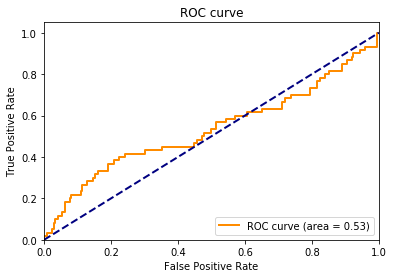

In [724]:
fpr, tpr, thr = roc_curve(1 - y_test[:, 5], score, pos_label=1)
roc_auc = auc(fpr, tpr)


plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

In [725]:
best_thr = thr[np.argmin((0 - fpr)**2 + (1 - tpr)**2)] # Closest threshold to (0, 1) on ROC curve

In [726]:
predictions = [1 if x > best_thr else 0 for x in score] # After seeing ROC curve best threshold is ~0.3

In [727]:
conf_matrix = confusion_matrix(1 - y_test[:,5], predictions, )
conf_matrix

array([[159,  51],
       [ 36,  24]])

In [728]:
tn, fp, fn, tp = conf_matrix.ravel()

In [729]:
precision = tp / (tp + fp)
precision

0.32

In [730]:
recall = tp / (tp + fn)
recall

0.4

In [731]:
fscore = 2 * precision * recall / (precision + recall)
fscore

0.35555555555555557

In [734]:
accuracy_score(1-y_test[:, 5],predictions)

0.762962962962963

## Multiclass Model Hyperparameter Search

In [357]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [96]:
# class_weights = class_weight.compute_class_weight('balanced', 
#                                                  np.unique(np.argmax(y_train, 1)), 
#                                                  np.argmax(y_train,1))
# class_weights

array([ 1.15533981,  1.88888889, 14.875     ,  1.7761194 ,  5.40909091,
        0.26385809])

In [479]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [640]:
def create_model(hidden_size=60, dropout=0.2, recurrent_dropout=0.5):
    model = Sequential()
    model.add(LSTM(hidden_size, input_shape=(WINDOW_SIZE, 1),
                  dropout=dropout, recurrent_dropout=recurrent_dropout))
    model.add(Dense(6, activation='softmax')) 
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam')
    return model

In [360]:
# Custom TransformerMixin to reshape data after oversampling

# from sklearn.base import TransformerMixin

# class Reshape(TransformerMixin):

#     def transform(self, X):
        
#         return X.reshape(*X.shape, 1)

#     def fit(self, X, y=None, **fit_params):
#         return self

# Saved in utils.py

In [78]:
from imblearn.metrics import geometric_mean_score
from imblearn.metrics import classification_report_imbalanced

In [355]:
from utils import Reshape

In [ ]:
model = Pipeline([
    ('sampling', RandomOverSampler()),# Try with SMOTE 
    ('reshape', Reshape()),
    ('clf', KerasClassifier(create_model, verbose=0))
])

# Grid search parameters
hidden_size = [60, 80, 100, 150]
epochs = [30, 40, 50, 60, 70]
batch_size = [8, 16, 32]
dropout = [0.2, 0.5]
recurrent_dropout = [0.2, 0.5]


scoring={'f1_macro':'f1_macro', 
         'f1_micro':'f1_micro', 
         'gms_macro':make_scorer(geometric_mean_score, average='macro'), 
         'gms_micro':make_scorer(geometric_mean_score, average='micro')}

param_grid = {'clf__hidden_size':hidden_size,
              'clf__batch_size':batch_size,
              'clf__epochs':epochs,
              'clf__dropout':dropout,
              'clf__recurrent_dropout':recurrent_dropout}

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=5, n_jobs=-1, refit='f1_macro')

grid_search = grid.fit(X_train, np.argmax(y_train, axis=1))


# hyperas module for optimizing hyperparameters

/root/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [632]:
grid_search.best_params_, grid_search.best_score_

({'clf__batch_size': 32,
  'clf__dropout': 0.2,
  'clf__epochs': 60,
  'clf__hidden_size': 60,
  'clf__recurrent_dropout': 0.5},
 0.2319766292278518)

In [633]:
predictions = to_categorical(grid_search.predict(X_test))

In [634]:
sum(predictions)

array([17.,  8., 26., 20., 30., 71.], dtype=float32)

In [638]:
scores = grid_search.cv_results_['mean_test_f1_macro']
# f1_micro = grid_search.cv_results_['mean_test_f1_micro']
# f1_macro = grid_search.cv_results_['mean_test_f1_macro']
params = grid_search.cv_results_['params']

for score, param in zip(scores, params):
    if score > 0.212:
        print(score, param)
# [x for x in zip(grid_search.cv_results_['mean_test_score'], grid_search.cv_results_['params'])]

0.21265303021860948 {'clf__batch_size': 16, 'clf__dropout': 0.1, 'clf__epochs': 40, 'clf__hidden_size': 80, 'clf__recurrent_dropout': 0.5}
0.2136637002525996 {'clf__batch_size': 16, 'clf__dropout': 0.5, 'clf__epochs': 40, 'clf__hidden_size': 60, 'clf__recurrent_dropout': 0.2}
0.21307886293316866 {'clf__batch_size': 16, 'clf__dropout': 0.5, 'clf__epochs': 40, 'clf__hidden_size': 60, 'clf__recurrent_dropout': 0.5}
0.2124888333981779 {'clf__batch_size': 32, 'clf__dropout': 0.1, 'clf__epochs': 30, 'clf__hidden_size': 80, 'clf__recurrent_dropout': 0.1}
0.21593853820719175 {'clf__batch_size': 32, 'clf__dropout': 0.1, 'clf__epochs': 30, 'clf__hidden_size': 100, 'clf__recurrent_dropout': 0.5}
0.21898960483385288 {'clf__batch_size': 32, 'clf__dropout': 0.1, 'clf__epochs': 60, 'clf__hidden_size': 80, 'clf__recurrent_dropout': 0.2}
0.21301000999762632 {'clf__batch_size': 32, 'clf__dropout': 0.2, 'clf__epochs': 30, 'clf__hidden_size': 60, 'clf__recurrent_dropout': 0.5}
0.21233234567020767 {'clf__b

In [639]:
geometric_mean_score(np.argmax(y_test, 1), np.argmax(predictions, 1), average='macro')

0.504833998968837

In [577]:
f1_score(np.argmax(y_test, 1), np.argmax(predictions, 1), average='macro')

0.1961044021338139

In [585]:
def evaluate_model(estimator, runs=10):
    
    metrics = ['precision_macro', 'precision_micro', 'recall_macro', 'recall_micro',
              'f1_macro', 'f1_micro', 'gms_macro', 'gms_micro']
    results = {m:[] for m in metrics}

    for _ in range(runs):
        model = estimator
        model.fit(X_train, np.argmax(y_train, 1))
        y_pred = model.predict(X_test)

        results['precision_macro'].append(precision_score(np.argmax(y_test,1), y_pred, average='macro'))
        results['precision_micro'].append(precision_score(np.argmax(y_test,1), y_pred, average='micro')) 
        results['recall_macro'].append(recall_score(np.argmax(y_test,1), y_pred, average='macro'))
        results['recall_micro'].append(recall_score(np.argmax(y_test,1), y_pred, average='micro'))
        results['f1_macro'].append(f1_score(np.argmax(y_test,1), y_pred, average='macro'))
        results['f1_micro'].append(f1_score(np.argmax(y_test,1), y_pred, average='micro'))
        results['gms_macro'].append(geometric_mean_score(np.argmax(y_test,1), y_pred, average='macro'))
        results['gms_micro'].append(geometric_mean_score(np.argmax(y_test,1), y_pred, average='micro'))
    
    return results

In [655]:
from matplotlib.colors import to_hex
from eli5.sklearn import PermutationImportance
import eli5

def color_dataframe(row):
    color = to_hex(plt.cm.RdBu(row.weight* 10 +0.5))
    return pd.Series('background-color: %s' % color, row.index)

def permutation_importance(estimator, runs=10):
    weights = np.zeros(13)
    std = np.zeros(13)
    for _ in range(runs):
        model = estimator
        model.fit(X_train, np.argmax(y_train,1))

        perm = PermutationImportance(model, scoring='f1_macro').fit(X_test, np.argmax(y_test, 1))
        df = eli5.format_as_dataframe(eli5.explain_weights(perm, top=13, feature_names=[str(i) for i in range(13)]))
        df['feature'] = pd.to_numeric(df['feature'])
        df.sort_values(by='feature', inplace=True)
        weights += df['weight'].values
        std += df['std'].values
    weights /= runs
    std /= runs
    features = ['Var_Month'+ str(i) for i in range(0,13)]

    df_perm_importance = pd.DataFrame(data=np.vstack((weights, std)).T, columns=['weight', 'std'])
    df_perm_importance.insert(0, 'features', features)
    df_perm_importance.sort_values('weight', ascending=False, inplace=True)
    df_perm_importance.reset_index(drop=True, inplace=True)
    
    return df_perm_importance.style.apply(color_dataframe, axis=1)
    

## Multiclass Model

In [472]:
X_train = X_train.reshape(*X_train.shape, 1)
X_test = X_test.reshape(*X_test.shape, 1)

In [473]:
X_resampled = X_resampled.reshape(*X_resampled.shape, 1)

In [478]:
X_test = X_test.reshape(X_test.shape[:-1]).shape

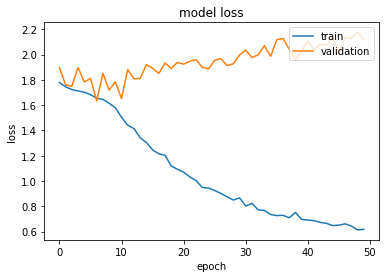

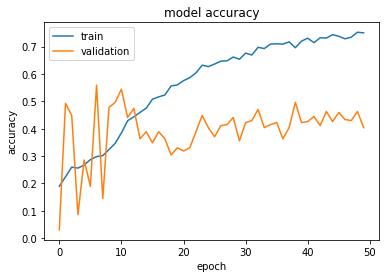

In [336]:
plot_model(history)

In [ ]:
# from keras.models import load_model
# model = load_model('models/binary_model.h5')

In [468]:
predictions = to_categorical(model.predict_classes(X_test))

In [469]:
predictions.sum(axis=0)

array([ 48.,  22.,   5.,  50.,  17., 128.], dtype=float32)

In [432]:
y_test.sum(axis=0)

array([ 22,  21,   3,  11,   5, 208])

## LSTM

In [643]:
# epochs=60, batch_size=32
model = Pipeline([
    ('sampling', RandomOverSampler()), 
    ('reshape', Reshape()),
    ('clf', KerasClassifier(create_model, epochs=100, batch_size=32, verbose=0, 
                            validation_split=0.15, 
                            callbacks=[EarlyStopping(patience=50, restore_best_weights=True)]))
])

results = evaluate_model(model)
for metric, value in results.items():
    print(metric, np.round(np.mean(value), 3))

precision_macro 0.207
precision_micro 0.41
recall_macro 0.189
recall_micro 0.41
f1_macro 0.187
f1_micro 0.41
gms_macro 0.404
gms_micro 0.602


In [ ]:
model = Pipeline([
    ('sampling', RandomOverSampler()), 
    ('reshape', Reshape()),
    ('clf', KerasClassifier(create_model, epochs=100, batch_size=32, verbose=0, 
                            validation_split=0.15, 
                            callbacks=[EarlyStopping(patience=50, restore_best_weights=True)]))
])

permutation_importance(model)

## Dummies

In [583]:
from sklearn.dummy import DummyClassifier

In [595]:
model = DummyClassifier('stratified')

results = evaluate_model(model, 100)
for metric, value in results.items():
    print(metric, np.round(np.mean(value), 3))

precision_macro 0.168
precision_micro 0.45
recall_macro 0.17
recall_micro 0.45
f1_macro 0.166
f1_micro 0.45
gms_macro 0.375
gms_micro 0.633


In [592]:
model = DummyClassifier('most_frequent')

results = evaluate_model(model, 100)
for metric, value in results.items():
    print(metric, np.round(np.mean(value), 3))

precision_macro 0.111
precision_micro 0.669
recall_macro 0.167
recall_micro 0.669
f1_macro 0.134
f1_micro 0.669
gms_macro 0.373
gms_micro 0.79


In [596]:
model = DummyClassifier('uniform')

results = evaluate_model(model, 100)
for metric, value in results.items():
    print(metric, np.round(np.mean(value), 3))

precision_macro 0.166
precision_micro 0.166
recall_macro 0.166
recall_micro 0.166
f1_macro 0.116
f1_micro 0.166
gms_macro 0.364
gms_micro 0.371


In [594]:
model = DummyClassifier('stratified')

results = evaluate_model(model, 100)
for metric, value in results.items():
    print(metric, np.round(np.mean(value), 3))

precision_macro 0.164
precision_micro 0.441
recall_macro 0.165
recall_micro 0.441
f1_macro 0.161
f1_micro 0.441
gms_macro 0.368
gms_micro 0.626


## kNN

In [497]:
from sklearn.neighbors import KNeighborsClassifier

In [603]:
model = Pipeline([
    ('sampling', RandomOverSampler()),
    ('clf', KNeighborsClassifier())
])

# Grid search parameters
n_neighbors = list(range(1,6))

scorer = make_scorer(f1_score, average='macro')

param_grid = {'clf__n_neighbors':n_neighbors}

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scorer, cv=5, n_jobs=-1)

grid_search = grid.fit(X_train, np.argmax(y_train, axis=1))

/root/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [604]:
grid_search.best_params_

{'clf__n_neighbors': 1}

In [606]:
model = Pipeline([
    ('sampling', RandomOverSampler()),
    ('clf', KNeighborsClassifier(1))
])

results = evaluate_model(model, runs=100)
for metric, value in results.items():
    print(metric, np.round(np.mean(value), 3))

precision_macro 0.153
precision_micro 0.541
recall_macro 0.162
recall_micro 0.541
f1_macro 0.157
f1_micro 0.541
gms_macro 0.373
gms_micro 0.701


In [664]:
model = Pipeline([
    ('sampling', RandomOverSampler()),
    ('clf', KNeighborsClassifier(1))
])

permutation_importance(model, 100)

,features,weight,std
0,Var_Month12,0.0419535,0.0176367
1,Var_Month5,0.037314,0.0176183
2,Var_Month2,0.0347209,0.0166942
3,Var_Month8,0.0336628,0.01591
4,Var_Month10,0.0274884,0.0175939
5,Var_Month1,0.0272326,0.0167377
6,Var_Month11,0.0269535,0.0186563
7,Var_Month7,0.0129419,0.0153399
8,Var_Month6,0.00639535,0.0162727
9,Var_Month4,0.00551163,0.0157321


## SVM

In [516]:
from sklearn.svm import SVC

In [534]:
model = Pipeline([
    ('sampling', RandomOverSampler()),
    ('clf', SVC())
])

# Grid search parameters
Cs = [0.1, 1, 10, 20, 30, 50]
gammas = [0.001, 0.01, 0.1, 1]

scorer = make_scorer(f1_score, average='macro')

param_grid = {'clf__C':Cs, 'clf__gamma':gammas}

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scorer, cv=5, n_jobs=-1)

grid_search = grid.fit(X_train, np.argmax(y_train, axis=1))

/root/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [535]:
grid_search.best_params_

{'clf__C': 30, 'clf__gamma': 0.01}

In [607]:
model = Pipeline([
    ('sampling', RandomOverSampler()),
    ('clf', SVC(C=30, gamma=0.01))
])

results = evaluate_model(model, runs=100)
for metric, value in results.items():
    print(metric, np.round(np.mean(value), 3))

precision_macro 0.217
precision_micro 0.447
recall_macro 0.181
recall_micro 0.447
f1_macro 0.192
f1_micro 0.447
gms_macro 0.396
gms_micro 0.631


In [665]:
model = Pipeline([
    ('sampling', RandomOverSampler()),
    ('clf', SVC(C=30, gamma=0.01))
])

permutation_importance(model, 100)

,features,weight,std
0,Var_Month9,0.0333256,0.0138782
1,Var_Month4,0.0282791,0.0127403
2,Var_Month2,0.0271512,0.0145662
3,Var_Month1,0.0268837,0.0143988
4,Var_Month3,0.026314,0.0134974
5,Var_Month5,0.0155233,0.0116542
6,Var_Month0,0.0135465,0.0128958
7,Var_Month6,0.0109419,0.0111337
8,Var_Month10,0.00996512,0.0135422
9,Var_Month8,0.00793023,0.0144103


## Gradient Boost

In [616]:
from sklearn.ensemble import GradientBoostingClassifier

In [621]:
model = Pipeline([
    ('sampling', RandomOverSampler()),
    ('clf', GradientBoostingClassifier())
])

parameters = {
    "clf__learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "clf__min_samples_split": np.linspace(0.1, 0.5, 12),
    "clf__min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "clf__max_depth":[3,5,8, None]
    }

clf = GridSearchCV(model, parameters, scoring='f1_macro', cv=5, n_jobs=-1)
clf.fit(X_train, np.argmax(y_train,1))


/root/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('sampling', RandomOverSampler(random_state=None, ratio=None, return_indices=False,
         sampling_strategy='auto')), ('clf', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_...    subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'clf__learning_rate': [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2], 'clf__min_samples_split': array([0.1    , 0.13636, 0.17273, 0.20909, 0.24545, 0.28182, 0.31818,
       0.35455, 0.39091, 0.42727, 0.46364, 0.5    ]), 'clf__min_samples_leaf': array([0.1    , 0.13636, 0.17273, 0.20909, 0.24545, 0.28182, 0.31818,
       0.35455, 0.39091, 0.42727, 0.46364, 0.5    ]), 'clf__max_depth': [3, 5, 8, None]},
       pre_dispatch='2*n_jobs',

In [627]:
clf.best_params_

{'clf__learning_rate': 0.075,
 'clf__max_depth': 5,
 'clf__min_samples_leaf': 0.13636363636363638,
 'clf__min_samples_split': 0.390909090909091}

In [630]:
model = Pipeline([
    ('sampling', RandomOverSampler()),
    ('clf', GradientBoostingClassifier())
])

results = evaluate_model(model, runs=10)
for metric, value in results.items():
    print(metric, np.round(np.mean(value), 3))

/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/

precision_macro 0.209
precision_micro 0.558
recall_macro 0.219
recall_micro 0.558
f1_macro 0.212
f1_micro 0.558
gms_macro 0.438
gms_micro 0.713


/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


<BarContainer object of 13 artists>

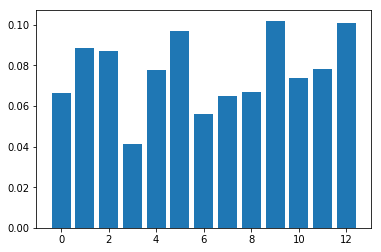

In [662]:
model = Pipeline([
    ('sampling', RandomOverSampler()),
    ('clf', GradientBoostingClassifier())
])
model.fit(X_train, np.argmax(y_train,1))

plt.bar(range(13), model.steps[1][1].feature_importances_)

In [666]:
model = Pipeline([
    ('sampling', RandomOverSampler()),
    ('clf', GradientBoostingClassifier())
])

permutation_importance(model, 100)

,features,weight,std
0,Var_Month12,0.0610698,0.0194242
1,Var_Month10,0.0168953,0.0122272
2,Var_Month5,0.0109767,0.0107203
3,Var_Month3,0.008,0.0128344
4,Var_Month6,0.00797674,0.013167
5,Var_Month8,0.00543023,0.0106056
6,Var_Month9,0.00522093,0.0100123
7,Var_Month0,0.00512791,0.0104671
8,Var_Month11,0.00480233,0.0146452
9,Var_Month1,0.00201163,0.0113239


## Multiclass Baseline (RandomForest)

In [612]:
model = Pipeline([
    ('sampling', RandomOverSampler()),
    ('clf', RandomForestClassifier())
])

# Grid search parameters
n_estimators = [10, 50, 100, 150, 200]
max_depth = [3, 5, 7, 9, 11, 13, 15, None]

scorer = make_scorer(f1_score, average='macro')

param_grid = {'clf__n_estimators':n_estimators, 'clf__max_depth':max_depth}

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scorer, cv=5, n_jobs=-1)

grid_search = grid.fit(X_train, np.argmax(y_train, axis=1))

/root/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [613]:
grid_search.best_params_

{'clf__max_depth': 5, 'clf__n_estimators': 100}

In [615]:
model = Pipeline([
    ('sampling', RandomOverSampler()),
    ('clf', RandomForestClassifier(150, max_depth=5))
])

results = evaluate_model(model, runs=100)
for metric, value in results.items():
    print(metric, np.round(np.mean(value), 3))

precision_macro 0.215
precision_micro 0.488
recall_macro 0.213
recall_micro 0.488
f1_macro 0.203
f1_micro 0.488
gms_macro 0.432
gms_micro 0.662


<BarContainer object of 13 artists>

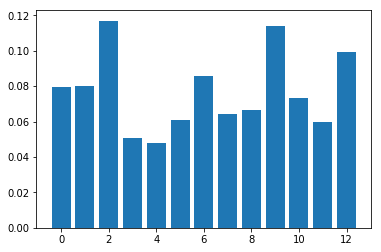

In [559]:
plt.bar(range(13), grid_search.best_estimator_.steps[1][1].feature_importances_)

In [667]:
model = Pipeline([
    ('sampling', RandomOverSampler()),
    ('clf', RandomForestClassifier(150, max_depth=5))
])

permutation_importance(model, 100)

,features,weight,std
0,Var_Month12,0.044,0.014625
1,Var_Month9,0.0316163,0.0148163
2,Var_Month5,0.0167326,0.010357
3,Var_Month6,0.0159884,0.0139383
4,Var_Month0,0.0108721,0.0127376
5,Var_Month7,0.00917442,0.0103353
6,Var_Month10,0.0069186,0.0109385
7,Var_Month11,0.0055,0.00996137
8,Var_Month2,0.00496512,0.0109927
9,Var_Month3,0.00190698,0.00770147


## tslearn

In [ ]:
import ts

In [387]:
X_resampled = X_resampled.reshape(*X_resampled.shape[:2])
X_train = X_train.reshape(*X_train.shape[:2])
X_test = X_test.reshape(*X_test.shape[:2])

In [388]:
X_resampled.shape

(2580, 13)

In [422]:
def plot_feature_importances(model, ax):
    n_features = WINDOW_SIZE
    ax.barh(range(n_features), model.feature_importances_, align='center')
#     ax.yticks(np.arange(n_features))
#     ax.setxlabel("Feature importance")
#     ax.ylabel("Feature")
#     ax.ylim(-1, n_features)

<BarContainer object of 13 artists>

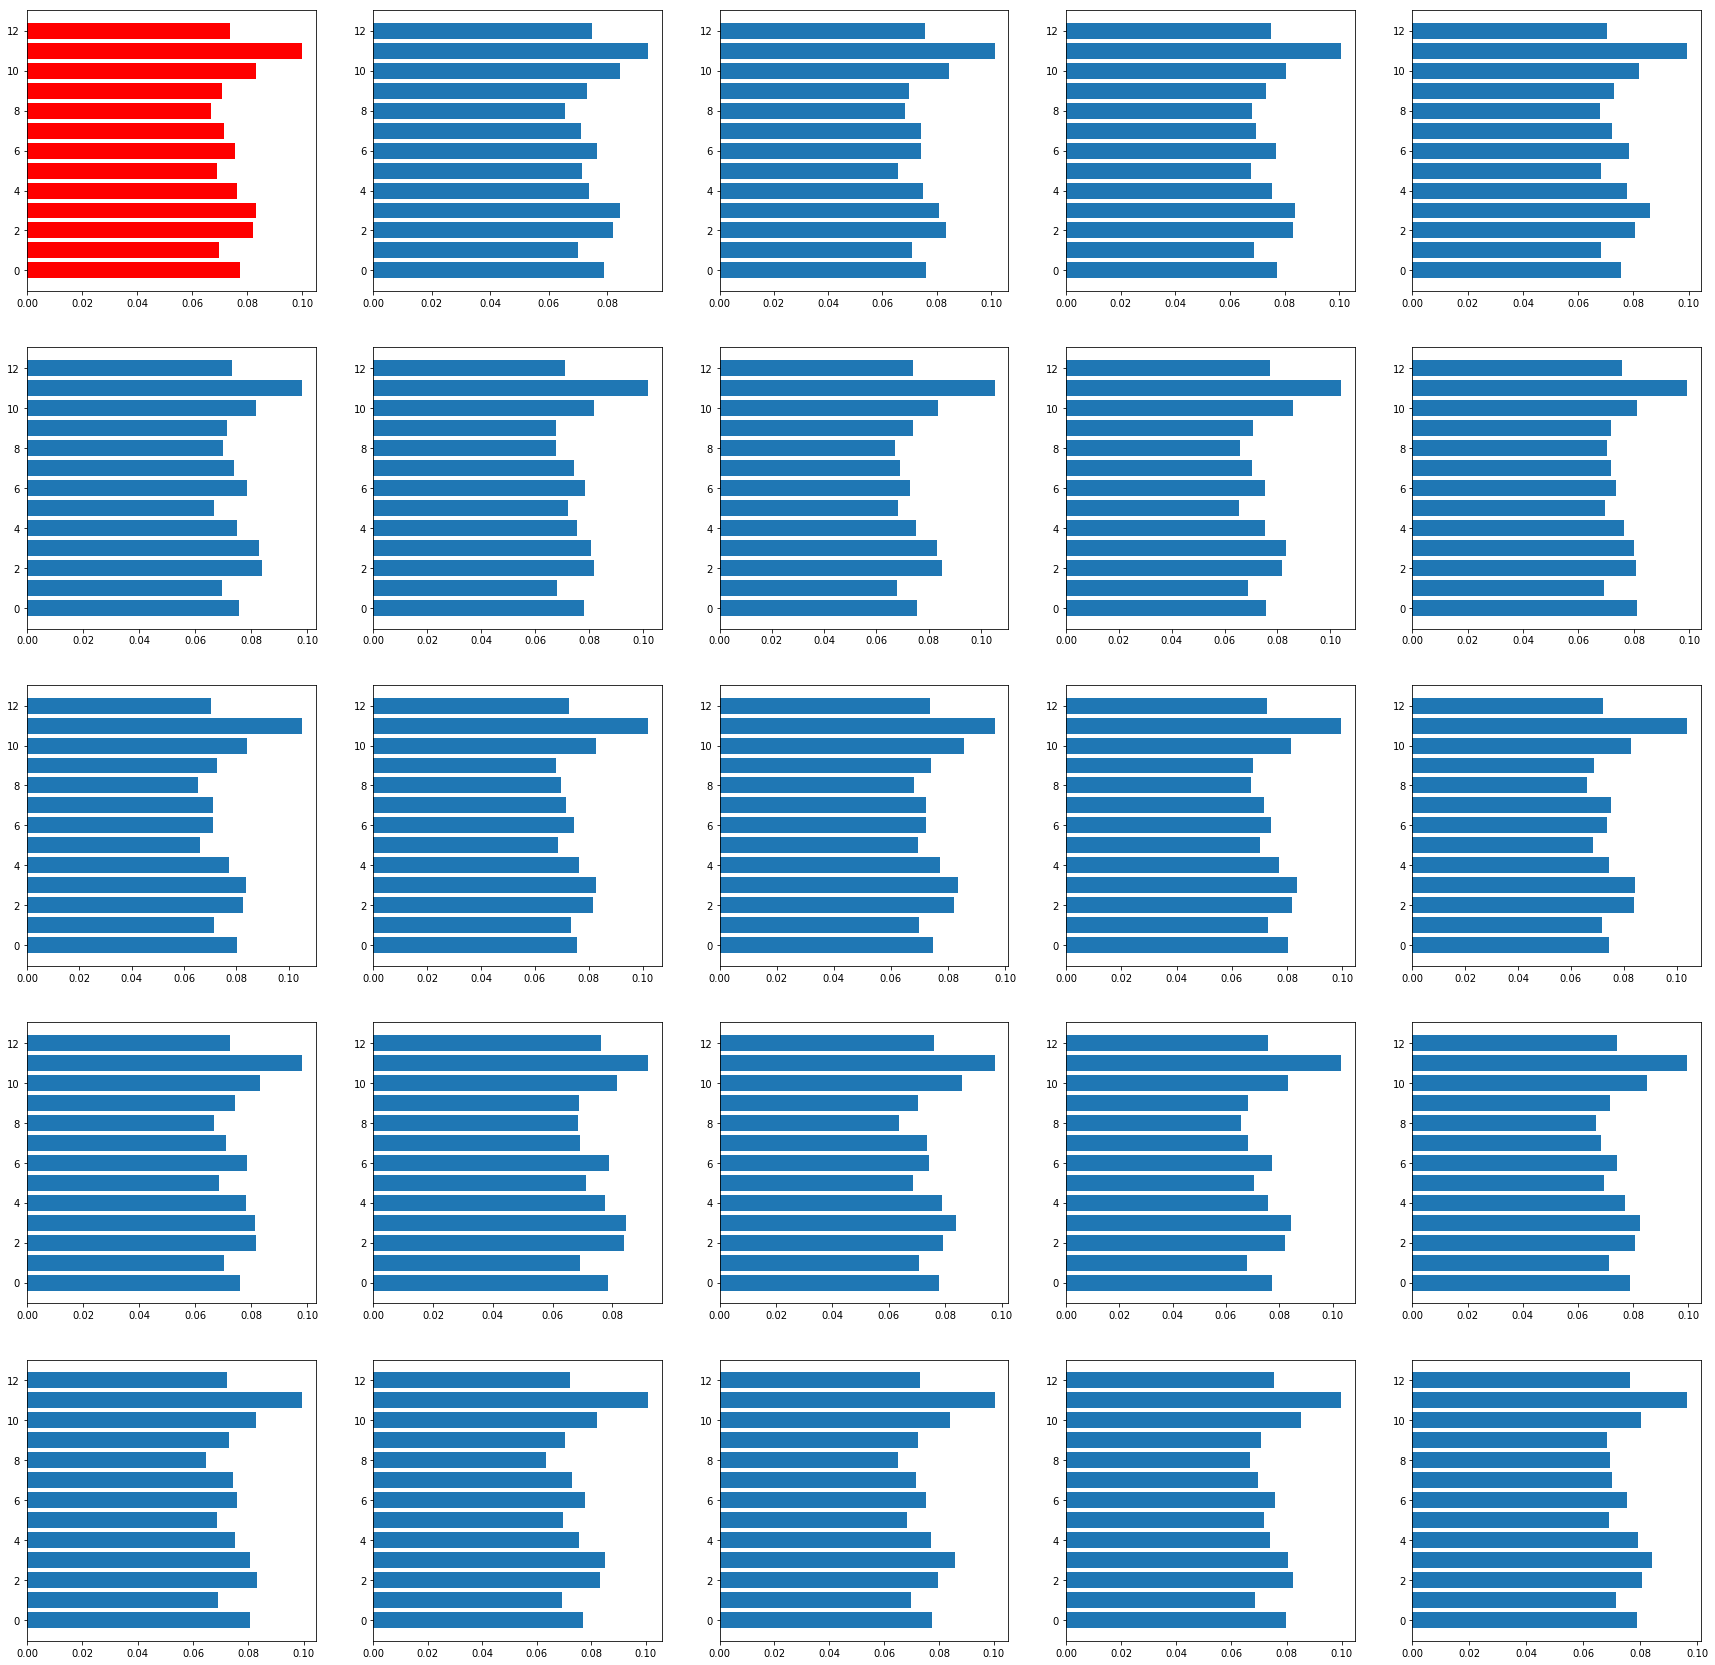

In [409]:
fig, axs = plt.subplots(5,5, figsize=(30,30))

axs = axs.ravel()

average_feature_importance = np.zeros(WINDOW_SIZE)
for i in range(1, 25):
    rf = RandomForestClassifier(200)
    rf.fit(X_resampled, np.argmax(y_resampled, 1))
    average_feature_importance += rf.feature_importances_
    plot_feature_importances(rf, axs[i])
average_feature_importance /= 24
axs[0].barh(range(WINDOW_SIZE), average_feature_importance, align='center', color='r')

## tslearn

In [718]:
from tslearn.shapelets import ShapeletModel, grabocka_params_to_shapelet_size_dict
from keras.optimizers import Adagrad

In [769]:

shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=X_resampled.shape[0],
                                                       ts_sz=X_resampled.shape[1],
                                                       n_classes=6,
                                                       l=0.3,
                                                       r=2)

In [770]:
shp_clf = ShapeletModel(n_shapelets_per_size=shapelet_sizes,
                        optimizer=Adagrad(lr=.1),
                        weight_regularizer=.01,
                        max_iter=50,
                        verbose_level=0)
shp_clf.fit(X_resampled.reshape(*X_resampled.shape, 1), np.argmax(y_resampled,1))

ShapeletModel(batch_size=256, max_iter=50, n_shapelets_per_size={3: 5, 6: 5},
       optimizer=<keras.optimizers.Adagrad object at 0x7f728a94c9e8>,
       random_state=None, verbose_level=0, weight_regularizer=0.01)

In [771]:
f1_score(shp_clf.predict(X_test.reshape(*X_test.shape, 1)), np.argmax(y_test,1), average='macro')

0.18047832060896404

In [772]:
confusion_matrix(shp_clf.predict(X_test.reshape(*X_test.shape, 1)), np.argmax(y_test,1))

array([[ 2,  0,  0,  1,  0,  3],
       [ 2,  2,  0,  3,  4,  8],
       [ 5,  1,  0,  2,  0, 14],
       [ 1,  0,  0,  1,  1,  3],
       [10,  2,  1,  4,  1, 22],
       [ 3,  5,  0,  4,  2, 65]])

In [775]:
predicted_locations = shp_clf.locate(X_test)

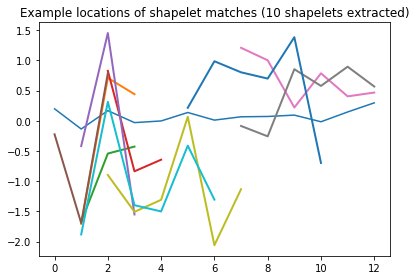

In [778]:

test_ts_id = 20
plt.figure()
plt.title("Example locations of shapelet matches (%d shapelets extracted)" % sum(shapelet_sizes.values()))
plt.plot(X_test[test_ts_id].ravel())
for idx_shp, shp in enumerate(shp_clf.shapelets_):
    t0 = predicted_locations[test_ts_id, idx_shp]
    plt.plot(np.arange(t0, t0 + len(shp)), shp, linewidth=2)

plt.tight_layout()
plt.show()

In [780]:
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
knn_clf = KNeighborsTimeSeriesClassifier(n_neighbors=3, metric="dtw")
knn_clf.fit(X_resampled, y_resampled)
predicted_labels = knn_clf.predict(X_test)
f1_score(predicted_labels, y_test, average='macro')

0.1868386652906777

In [779]:
knn_clf = KNeighborsTimeSeriesClassifier(n_neighbors=3, metric="euclidean")
knn_clf.fit(X_resampled, y_resampled)
predicted_labels = knn_clf.predict(X_test)
f1_score(predicted_labels, y_test, average='macro')

0.1535036778939218